In [ ]:
# Part A.1: Binary Logistic Regression from Scratch
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

## Binary Logistic Regression (Labels 0 vs 1)

### Step 1: Load and Prepare the Data

Load the MNIST data and filter only rows with labels 0 and 1.


In [64]:
# Load the data
df = pd.read_csv('mnist_train.csv')

# Display basic information
print(f"Original data shape: {df.shape}")

# Filter only labels 0 and 1
binary_data = df[df.iloc[:, 0].isin([0, 1])].copy()
print(f"\nBinary data shape (0 and 1 only): {binary_data.shape}")

# Separate features (pixels) and labels
X = binary_data.iloc[:, 1:].values  # All columns except first (pixel values)
y = binary_data.iloc[:, 0].values   # First column (labels)

# Normalize pixel values from [0, 255] to [0, 1]
X = X / 255.0

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

print(f"\nFeatures shape: {X_tensor.shape}")
print(f"Labels shape: {y_tensor.shape}")


Original data shape: (60000, 785)

Binary data shape (0 and 1 only): (12665, 785)

Features shape: torch.Size([12665, 784])
Labels shape: torch.Size([12665])


### Split Data into Train, Validation, and Test Sets


In [65]:
# Test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)

# Separate train and validation (80% train, 20% validation of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")


Training set: 7599 samples
Validation set: 2533 samples
Test set: 2533 samples
Feature dimension: 784


### Functions from Scratch

We need to implement three key components:
1. **Sigmoid function**: Maps any real number to [0,1] for probability
2. **Binary Cross Entropy Loss**: Measures how wrong our predictions are
3. **Logistic Regression Model**: The actual model that learns


In [66]:
# Sigmoid function: σ(z) = 1 / (1 + e^(-z))
def sigmoid(z):
    # Clip z to avoid overflow in exp(-z) when z is very negative
    z_clipped = torch.clamp(z, min=-500, max=500)
    return 1 / (1 + torch.exp(-z_clipped))


In [67]:
# Binary Cross Entropy Loss: L = -(y*log(p) + (1-y)*log(1-p))
# y is the true label and p is the predicted probability
def binary_cross_entropy_loss(y_pred, y_true):
    # Add small constant to avoid log(0)
    constant = 1e-15
    y_pred_clipped = torch.clamp(y_pred, constant, 1 - constant)
    
    # BCE formula: -[y*log(p) + (1-y)*log(1-p)]
    loss = -(y_true * torch.log(y_pred_clipped) + (1 - y_true) * torch.log(1 - y_pred_clipped))
    
    # Return average loss
    return torch.mean(loss)


In [68]:
# Logistic Regression Model from Scratch
# The model: p = σ(X @ w + b)
class LogisticRegression:
    
    def __init__(self, n_features, learning_rate=0.01):

        self.learning_rate = learning_rate
        # Initialize weights with small random values
        self.weights = torch.randn(n_features, requires_grad=False) * 0.01
        # Initialize bias with 0
        self.bias = torch.tensor(0.0, requires_grad=False)
        
    def forward(self, X):
        # Linear combination: z = X @ w + b
        z = X @ self.weights + self.bias
        # Apply sigmoid to get probabilities
        probabilities = sigmoid(z)
        return probabilities
    
    def predict(self, X):
    
        probabilities = self.forward(X)
        # If probability >= 0.5, predict class 1, else class 0
        return (probabilities >= 0.5).float()
    
    def compute_loss(self, X, y_true):
        
        y_pred = self.forward(X)
        return binary_cross_entropy_loss(y_pred, y_true)
    
    def compute_accuracy(self, X, y_true):
        
        predictions = self.predict(X)
        correct = (predictions == y_true).float()
        return torch.mean(correct).item()


# Initialize model
model = LogisticRegression(n_features=X_train.shape[1], learning_rate=0.01)
print(f"Model initialized!")
print(f"Weight shape: {model.weights.shape}")
print(f"Initial bias: {model.bias.item():.4f}")


Model initialized!
Weight shape: torch.Size([784])
Initial bias: 0.0000


### Create DataLoaders

Create DataLoaders for training, validation, and test sets.


In [69]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset objects (puts features and labels together)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True  # Shuffle for training to avoid learning order
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


### Implement Gradient Descent Training

Gradient descent updates weights using the gradient of the loss function. We'll compute gradients manually using the mathematical formulas.


In [70]:
def train_epoch(model, train_loader):
    total_loss = 0.0
    total_samples = 0
    
    # Process each batch
    for batch_X, batch_y in train_loader:
        n_batch = batch_X.shape[0]
        total_samples += n_batch
        
        # Forward pass: compute predictions for this batch
        y_pred = model.forward(batch_X)
        
        # Compute loss for this batch
        batch_loss = model.compute_loss(batch_X, batch_y)
        total_loss += batch_loss.item() * n_batch  # Weight by batch size
        
        # BCE loss with sigmoid:
        # dL/dw = (1/n) * X^T @ (y_pred - y_true)
        # dL/db = (1/n) * sum(y_pred - y_true)
        error = y_pred - batch_y
        grad_weights = (batch_X.t() @ error) / n_batch
        grad_bias = torch.mean(error)
        
        # Update weights using gradient descent (mini-batch update)
        # w = w - learning_rate * gradient
        model.weights = model.weights - model.learning_rate * grad_weights
        model.bias = model.bias - model.learning_rate * grad_bias
    
    # Return average loss across all batches
    return total_loss / total_samples


In [73]:
# Helper function to evaluate using DataLoader
def evaluate(model, data_loader):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_X, batch_y in data_loader:
            n_batch = batch_X.shape[0]
            total_samples += n_batch
            
            # Compute predictions
            predictions = model.predict(batch_X)
            total_correct += (predictions == batch_y).sum().item()
            batch_loss = model.compute_loss(batch_X, batch_y)
            total_loss += batch_loss.item() * n_batch
    
    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples
    
    return avg_loss, accuracy


# Training loop with convergence detection
print("Starting training")

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training parameters
max_epochs = 1000  # Number of epochs
patience = 100  # Number of epochs to wait before stopping
min_delta = 1e-6  # Small threshold - stop when improvement is tiny

best_val_loss = float('inf') 
best_epoch = 0 
epochs_no_improve = 0 # Number of epochs without improvement

for epoch in range(max_epochs):
    # Train each epoch
    train_loss = train_epoch(model, train_loader)
    
    # Evaluate on training set
    train_loss_eval, train_acc = evaluate(model, train_loader)
    
    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader)
    
    
    # Store history
    train_losses.append(train_loss_eval) 
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    
    if (epoch + 1) % 50 == 0 :
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    # Only update best_val_loss if current loss is valid and better
    if not torch.isnan(torch.tensor(val_loss)) and val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        # Early stopping: stop if no improvement for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"\n Early stopping at epoch {epoch+1}")
            print(f"  Best validation loss: {best_val_loss:.6f} (achieved at epoch {best_epoch})")
            break

# Check if we reached max epochs
if epoch == max_epochs - 1:
    print(f"\n  Reached maximum epochs ({max_epochs})")
    print(f"  Best validation loss: {best_val_loss:.6f} (achieved at epoch {best_epoch})")
    if epochs_no_improve < patience:
        print(f"  Model was still improving (no improvement for only {epochs_no_improve}/{patience} epochs)")
    else:
        print(f"  Final validation loss: {val_loss:.6f}")

print("\nTraining completed!")
print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"Total epochs trained: {len(train_losses)}")


Starting training
Epoch   50 | Train Loss: 0.002974 | Train Acc: 0.9995 | Val Loss: 0.008655 | Val Acc: 0.9968
Epoch  100 | Train Loss: 0.002629 | Train Acc: 0.9995 | Val Loss: 0.008557 | Val Acc: 0.9976
Epoch  150 | Train Loss: 0.002370 | Train Acc: 0.9996 | Val Loss: 0.008506 | Val Acc: 0.9976
Epoch  200 | Train Loss: 0.002166 | Train Acc: 0.9996 | Val Loss: 0.008482 | Val Acc: 0.9976
Epoch  250 | Train Loss: 0.002001 | Train Acc: 0.9997 | Val Loss: 0.008477 | Val Acc: 0.9976
Epoch  300 | Train Loss: 0.001863 | Train Acc: 0.9997 | Val Loss: 0.008481 | Val Acc: 0.9976

 Early stopping at epoch 349
  Best validation loss: 0.008477 (achieved at epoch 249)

Training completed!
Final training accuracy: 0.9997
Final validation accuracy: 0.9976
Total epochs trained: 349


### Training Curves

The training and validation loss and accuracy curves.


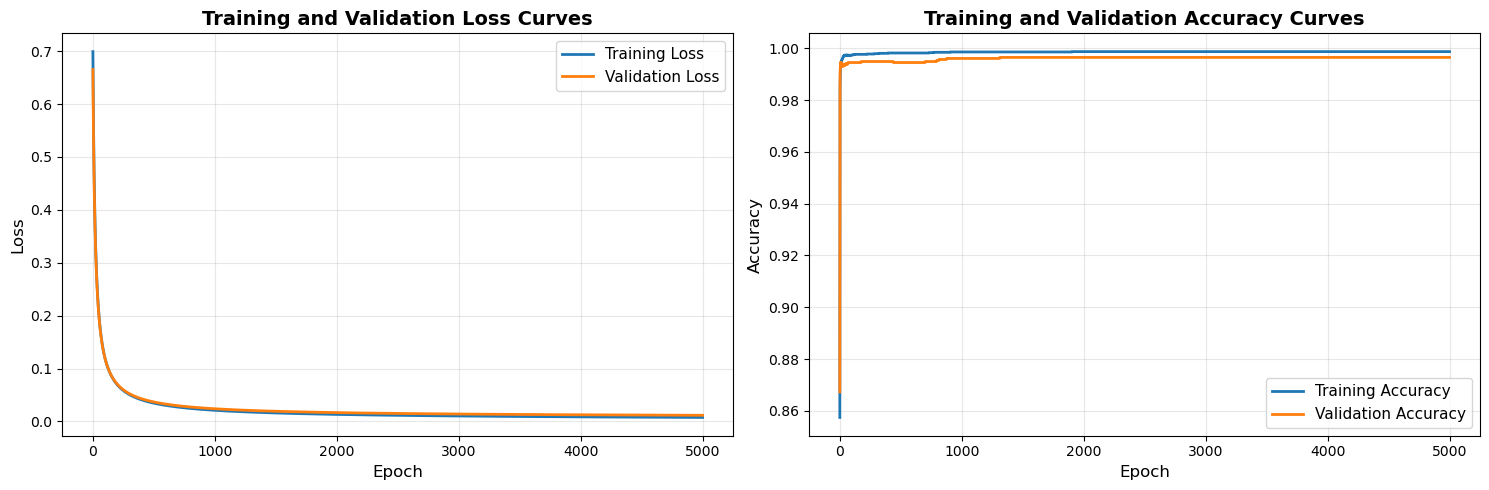

Training converged after 5000 epochs


In [ ]:
# Plot training and validation loss curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', linewidth=2)
plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Final Test Evaluation

Evaluate our model on the test set and create a confusion matrix.


In [ ]:
# Evaluate on test set using DataLoader
test_loss, test_accuracy = evaluate(model, test_loader, compute_loss=True)

print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")


FINAL TEST RESULTS
Test Accuracy: 0.9964 (99.64%)
Test Loss: 0.0117


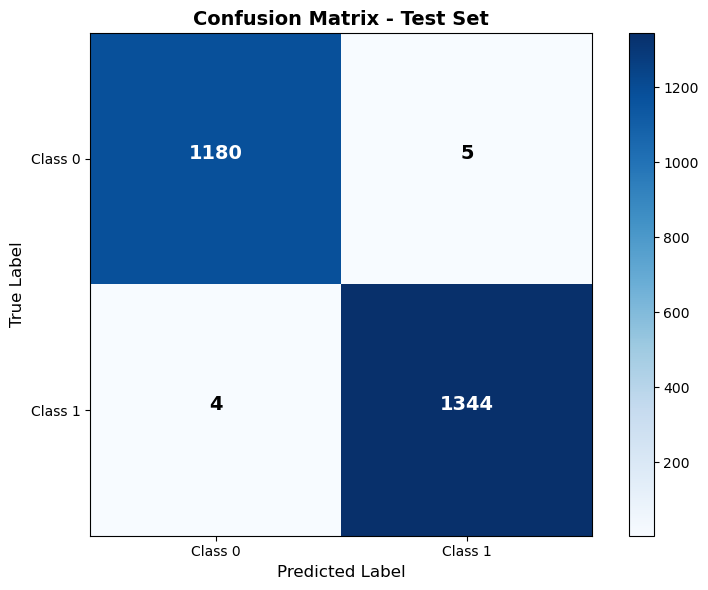


Confusion Matrix:
                Predicted
                0       1
Actual  0      1180      5
        1         4   1344

Interpretation:
- True Negatives (TN): 1180 - Correctly predicted class 0
- False Positives (FP): 5 - Predicted 1 but actually 0
- False Negatives (FN): 4 - Predicted 0 but actually 1
- True Positives (TP): 1344 - Correctly predicted class 1


In [ ]:
# Create confusion matrix (collect predictions from test DataLoader)
y_test_true = []
y_test_pred = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model.predict(batch_X)
        y_test_true.extend(batch_y.numpy())
        y_test_pred.extend(predictions.numpy())

# Convert to numpy arrays for confusion matrix
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

cm = confusion_matrix(y_test_true, y_test_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



### Softmac regression implementation: Load and Prepare ALL Classes

We'll use ALL 10 digit classes, not just 0 and 1.


In [ ]:
# Load the full MNIST dataset (all 10 classes)
df_multi = pd.read_csv('mnist_train.csv')

print(f"Full dataset shape: {df_multi.shape}")

# Separate features and labels for ALL classes
X_multi = df_multi.iloc[:, 1:].values  # Pixel values
y_multi = df_multi.iloc[:, 0].values    # Labels (0-9)

# Normalize pixel values from [0, 255] to [0, 1]
X_multi = X_multi / 255.0

# Convert to PyTorch tensors
# Important: labels must be LongTensor (int64) for multi-class classification
X_multi_tensor = torch.FloatTensor(X_multi)
y_multi_tensor = torch.LongTensor(y_multi) 



Full dataset shape: (60000, 785)

Label distribution (all 10 classes):
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

Features shape: torch.Size([60000, 784])
Labels shape: torch.Size([60000])
Label range: 0 to 9
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Split Data for Multi-Class Task


In [ ]:
# Split into train, validation, and test sets
X_temp_multi, X_test_multi, y_temp_multi, y_test_multi = train_test_split(
    X_multi_tensor, y_multi_tensor, test_size=0.2, random_state=42, stratify=y_multi_tensor
)

X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
    X_temp_multi, y_temp_multi, test_size=0.25, random_state=42, stratify=y_temp_multi
)

print(f"Multi-class dataset splits:")
print(f"  Training set: {X_train_multi.shape[0]} samples")
print(f"  Validation set: {X_val_multi.shape[0]} samples")
print(f"  Test set: {X_test_multi.shape[0]} samples")
print(f"  Number of classes: 10")
print(f"  Feature dimension: {X_train_multi.shape[1]}")


Multi-class dataset splits:
  Training set: 36000 samples
  Validation set: 12000 samples
  Test set: 12000 samples
  Number of classes: 10 (digits 0-9)
  Feature dimension: 784


In [ ]:
def softmax(z):
    # Numerical stability: subtract max to prevent overflow
    # This doesn't change the result due to softmax property:
    # softmax(z) = softmax(z - max(z))
    z_max = torch.max(z, dim=1, keepdim=True)[0]
    z_shifted = z - z_max
    
    exp_z = torch.exp(z_shifted)
    sum_exp_z = torch.sum(exp_z, dim=1, keepdim=True)
    probabilities = exp_z / sum_exp_z
    
    return probabilities


Testing softmax function:
Input logits:
tensor([[1., 2., 3.],
        [1., 1., 1.]])

Softmax output:
tensor([[0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])

Row sums (should be ~1.0): tensor([1., 1.])

✓ Softmax ensures outputs are probabilities that sum to 1!


### Implement Cross-Entropy Loss from Scratch

**Mathematical Formula:**
$$L = -\sum_{i=0}^{9} y_i \log(\hat{y}_i)$$


In [ ]:
def cross_entropy_loss(y_pred_probs, y_true_labels):
    n_samples = y_pred_probs.shape[0]
    n_classes = y_pred_probs.shape[1]
    
    # Clip probabilities to avoid log(0)
    constant = 1e-15
    y_pred_clipped = torch.clamp(y_pred_probs, constant, 1 - constant)
    
    # Convert true labels to one-hot encoding
    y_true_one_hot = torch.zeros(n_samples, n_classes)
    y_true_one_hot.scatter_(1, y_true_labels.unsqueeze(1), 1)
    
    # Cross-entropy formula: -sum(y_true * log(y_pred))
    log_probs = torch.log(y_pred_clipped)
    selected_log_probs = (y_true_one_hot * log_probs).sum(dim=1)
    
    # Cross-entropy is negative log probability of true class
    loss_per_sample = -selected_log_probs
    
    # Return average loss
    return torch.mean(loss_per_sample)


Testing cross-entropy loss:
Predicted probabilities:
tensor([[0.1000, 0.2000, 0.7000],
        [0.9000, 0.0500, 0.0500]])
True labels: tensor([2, 0])
Cross-entropy loss: 0.2310

Note: Lower loss when model is confident in correct class!


In [ ]:
class SoftmaxRegression:
    
    def __init__(self, n_features, n_classes=10, learning_rate=0.01):
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        
        # Initialize weight matrix with random values and bias with zeros
        self.weights = torch.randn(n_classes, n_features, requires_grad=False) * 0.01
        self.bias = torch.zeros(n_classes, requires_grad=False)
        
    def forward(self, X):
        # Linear combination: z = X @ W^T + b
        z = X @ self.weights.t() + self.bias
        
        # Apply softmax to get probabilities
        probabilities = softmax(z)
        return probabilities
    
    def predict(self, X):
        probabilities = self.forward(X)
        # Find class with highest probability for each sample
        predictions = torch.argmax(probabilities, dim=1)
        return predictions
    
    def compute_loss(self, X, y_true):
        y_pred_probs = self.forward(X)
        return cross_entropy_loss(y_pred_probs, y_true)
    
    def compute_accuracy(self, X, y_true):
        predictions = self.predict(X)
        correct = (predictions == y_true).float()
        return torch.mean(correct).item()


# Initialize model
model_scratch = SoftmaxRegression(n_features=X_train_multi.shape[1], n_classes=10, learning_rate=0.01)
print(f"Softmax Regression Model initialized!")
print(f"Weight matrix shape: {model_scratch.weights.shape} (10 classes × 784 features)")
print(f"Bias vector shape: {model_scratch.bias.shape} (10 classes)")
print(f"Total parameters: {model_scratch.weights.numel() + model_scratch.bias.numel()}")


Softmax Regression Model initialized!
Weight matrix shape: torch.Size([10, 784]) (10 classes × 784 features)
Bias vector shape: torch.Size([10]) (10 classes)
Total parameters: 7850


### Create DataLoaders for Multi-Class Data


In [79]:
# Create DataLoaders for multi-class classification
train_dataset_multi = TensorDataset(X_train_multi, y_train_multi)
val_dataset_multi = TensorDataset(X_val_multi, y_val_multi)
test_dataset_multi = TensorDataset(X_test_multi, y_test_multi)

batch_size_multi = 64

train_loader_multi = DataLoader(
    train_dataset_multi,
    batch_size=batch_size_multi,
    shuffle=True
)

val_loader_multi = DataLoader(
    val_dataset_multi,
    batch_size=batch_size_multi,
    shuffle=False
)

test_loader_multi = DataLoader(
    test_dataset_multi,
    batch_size=batch_size_multi,
    shuffle=False
)

print(f"Multi-class DataLoaders created:")
print(f"  Training batches: {len(train_loader_multi)}")
print(f"  Validation batches: {len(val_loader_multi)}")
print(f"  Test batches: {len(test_loader_multi)}")


Multi-class DataLoaders created:
  Training batches: 563
  Validation batches: 188
  Test batches: 188


In [ ]:
def train_epoch_softmax(model, train_loader):
    total_loss = 0.0
    total_samples = 0
    
    # Process each batch
    for batch_X, batch_y in train_loader:
        n_batch = batch_X.shape[0]
        total_samples += n_batch
        
        # Forward pass: compute predictions for this batch
        y_pred_probs = model.forward(batch_X) 
        
        # Compute loss for this batch
        batch_loss = model.compute_loss(batch_X, batch_y)
        total_loss += batch_loss.item() * n_batch
        
        # Compute gradients manually
        # Convert true labels to one-hot encoding
        n_classes = model.n_classes
        y_true_one_hot = torch.zeros(n_batch, n_classes)
        y_true_one_hot.scatter_(1, batch_y.unsqueeze(1), 1)
        
        error = y_pred_probs - y_true_one_hot 
        
        # Gradient for weights: (1/n) * X^T @ error
        grad_weights = (batch_X.t() @ error) / n_batch 
        
        # Gradient for bias: (1/n) * sum(error)
        grad_bias = torch.mean(error, dim=0)
        
        # Transpose grad_weights to match weight matrix shape (n_classes, n_features)
        grad_weights = grad_weights.t()
        
        # Update weights using gradient descent
        model.weights = model.weights - model.learning_rate * grad_weights
        model.bias = model.bias - model.learning_rate * grad_bias
    
    # Return average loss across all batches
    return total_loss / total_samples


def evaluate_softmax(model, data_loader):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            n_batch = batch_X.shape[0]
            total_samples += n_batch
            
            # Compute predictions
            predictions = model.predict(batch_X)
            total_correct += (predictions == batch_y).sum().item()
            
            # Compute loss
            batch_loss = model.compute_loss(batch_X, batch_y)
            total_loss += batch_loss.item() * n_batch
    
    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples
    
    return avg_loss, accuracy


In [ ]:
print("Training Softmax Regression Scratch Implementation ...")

# Initialize lists to store training history
train_losses_scratch = []
val_losses_scratch = []
train_accuracies_scratch = []
val_accuracies_scratch = []

# Training parameters (same as binary logistic regression)
max_epochs = 2000
patience = 100
min_delta = 1e-6

best_val_loss_scratch = float('inf')
best_epoch_scratch = 0
epochs_no_improve = 0

for epoch in range(max_epochs):
    # Train one epoch
    train_loss = train_epoch_softmax(model_scratch, train_loader_multi)
    
    # Evaluate on training and validation sets
    train_loss_eval, train_acc = evaluate_softmax(model_scratch, train_loader_multi)
    val_loss, val_acc = evaluate_softmax(model_scratch, val_loader_multi)
    
    
    # Store history
    train_losses_scratch.append(train_loss_eval)
    val_losses_scratch.append(val_loss)
    train_accuracies_scratch.append(train_acc)
    val_accuracies_scratch.append(val_acc)
    
    # Print progress
    if (epoch + 1) % 25 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss_eval:.6f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if not torch.isnan(torch.tensor(val_loss)) and val_loss < best_val_loss_scratch - min_delta:
        best_val_loss_scratch = val_loss
        best_epoch_scratch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping at epoch {epoch+1}")
            print(f"  Best validation loss: {best_val_loss_scratch:.6f} (achieved at epoch {best_epoch_scratch})")
            break

if epoch == max_epochs - 1:
    print(f"\n  Reached maximum epochs ({max_epochs})")
    print(f"  Best validation loss: {best_val_loss_scratch:.6f}")

print("\nTraining completed (From Scratch)!")
print(f"Final training accuracy: {train_accuracies_scratch[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies_scratch[-1]:.4f}")
print(f"Total epochs trained: {len(train_losses_scratch)}")


Training Softmax Regression (From Scratch)...
Epoch    1 | Train Loss: 0.758484 | Train Acc: 0.8433 | Val Loss: 0.766193 | Val Acc: 0.8380
Epoch    2 | Train Loss: 0.582692 | Train Acc: 0.8654 | Val Loss: 0.593662 | Val Acc: 0.8604
Epoch    3 | Train Loss: 0.511523 | Train Acc: 0.8738 | Val Loss: 0.524237 | Val Acc: 0.8681
Epoch    4 | Train Loss: 0.470709 | Train Acc: 0.8808 | Val Loss: 0.484230 | Val Acc: 0.8760
Epoch    5 | Train Loss: 0.444261 | Train Acc: 0.8862 | Val Loss: 0.458595 | Val Acc: 0.8800
Epoch    6 | Train Loss: 0.424943 | Train Acc: 0.8889 | Val Loss: 0.440063 | Val Acc: 0.8815
Epoch    7 | Train Loss: 0.410055 | Train Acc: 0.8914 | Val Loss: 0.425831 | Val Acc: 0.8848
Epoch    8 | Train Loss: 0.398404 | Train Acc: 0.8940 | Val Loss: 0.414416 | Val Acc: 0.8878
Epoch    9 | Train Loss: 0.388430 | Train Acc: 0.8959 | Val Loss: 0.404856 | Val Acc: 0.8890
Epoch   10 | Train Loss: 0.380228 | Train Acc: 0.8978 | Val Loss: 0.397086 | Val Acc: 0.8915
Epoch   50 | Train Loss:

### Comparison with PyTorch's Built-in Implementation

We implement the same model using PyTorch's built-in functions to verify our implementation


In [ ]:
# Create PyTorch model using built-in layers
class SoftmaxRegressionPyTorch(nn.Module):
    
    def __init__(self, n_features, n_classes=10):
        super(SoftmaxRegressionPyTorch, self).__init__()
        # Linear layer: automatically handles weights and bias
        self.linear = nn.Linear(n_features, n_classes)
        
    def forward(self, X):
        # Linear transformation (X @ W^T + b)
        logits = self.linear(X)
        # Softmax activation
        probabilities = F.softmax(logits, dim=1)
        return probabilities
    
    def predict(self, X):
        with torch.no_grad():
            probabilities = self.forward(X)
            predictions = torch.argmax(probabilities, dim=1)
        return predictions


# Initialize PyTorch model
model_pytorch = SoftmaxRegressionPyTorch(n_features=X_train_multi.shape[1], n_classes=10)

# Use PyTorch's cross-entropy loss includes softmax internally
criterion = nn.CrossEntropyLoss()

# Manual gradient descent optimizer
learning_rate = 0.01

print("PyTorch model initialized!")
print(f"Model structure: {model_pytorch}")
print(f"Total parameters: {sum(p.numel() for p in model_pytorch.parameters())}")


PyTorch model initialized!
Model structure: SoftmaxRegressionPyTorch(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
Total parameters: 7850


In [ ]:
def train_epoch_pytorch(model, train_loader, criterion, lr):
    total_loss = 0.0
    total_samples = 0
    
    model.train()  # Set to training mode
    
    for batch_X, batch_y in train_loader:
        n_batch = batch_X.shape[0]
        total_samples += n_batch
        
        # Forward pass: get logits before softmax
        logits = model.linear(batch_X)  
        
        # Compute loss CrossEntropyLoss includes softmax internally
        loss = criterion(logits, batch_y)
        total_loss += loss.item() * n_batch
        
        # Manual gradient computation and update
        # PyTorch's CrossEntropyLoss gradient for softmax is: (probs - one_hot) / n
        probs = F.softmax(logits, dim=1)
        y_one_hot = torch.zeros_like(probs)
        y_one_hot.scatter_(1, batch_y.unsqueeze(1), 1)
        
        grad = (probs - y_one_hot) / n_batch
        
        # Compute gradients for weights and bias
        grad_weights = batch_X.t() @ grad 
        grad_bias = grad.sum(dim=0)  
        
        # Update weights and bias manually
        with torch.no_grad():
            model.linear.weight -= lr * grad_weights.t()
            model.linear.bias -= lr * grad_bias
    
    return total_loss / total_samples


def evaluate_pytorch(model, data_loader, criterion):
    """Evaluate PyTorch model"""
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    model.eval()  # Set to evaluation mode
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            n_batch = batch_X.shape[0]
            total_samples += n_batch
            
            logits = model.linear(batch_X)
            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == batch_y).sum().item()
            
            loss = criterion(logits, batch_y)
            total_loss += loss.item() * n_batch
    
    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples
    
    return avg_loss, accuracy


In [ ]:
# Training loop for PyTorch implementation
print("\nTraining Softmax Regression PyTorch Built-in implementation...")

# Initialize lists to store training history
train_losses_pytorch = []
val_losses_pytorch = []
train_accuracies_pytorch = []
val_accuracies_pytorch = []

# Same training parameters
best_val_loss_pytorch = float('inf')
best_epoch_pytorch = 0
epochs_no_improve = 0

for epoch in range(max_epochs):
    # Train one epoch
    train_loss = train_epoch_pytorch(model_pytorch, train_loader_multi, criterion, learning_rate)
    
    # Evaluate
    train_loss_eval, train_acc = evaluate_pytorch(model_pytorch, train_loader_multi, criterion)
    val_loss, val_acc = evaluate_pytorch(model_pytorch, val_loader_multi, criterion)
    
    
    # Store history
    train_losses_pytorch.append(train_loss_eval)
    val_losses_pytorch.append(val_loss)
    train_accuracies_pytorch.append(train_acc)
    val_accuracies_pytorch.append(val_acc)
    
    # Print progress
    if (epoch + 1) % 25 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss_eval:.6f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if not torch.isnan(torch.tensor(val_loss)) and val_loss < best_val_loss_pytorch - min_delta:
        best_val_loss_pytorch = val_loss
        best_epoch_pytorch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping at epoch {epoch+1}")
            print(f"  Best validation loss: {best_val_loss_pytorch:.6f} (achieved at epoch {best_epoch_pytorch})")
            break

if epoch == max_epochs - 1:
    print(f"\n  Reached maximum epochs ({max_epochs})")
    print(f"  Best validation loss: {best_val_loss_pytorch:.6f}")

print("\nTraining completed (PyTorch Built-in)!")
print(f"Final training accuracy: {train_accuracies_pytorch[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies_pytorch[-1]:.4f}")
print(f"Total epochs trained: {len(train_losses_pytorch)}")



Training Softmax Regression (PyTorch Built-in)...
Epoch    1 | Train Loss: 0.760152 | Train Acc: 0.8446 | Val Loss: 0.768407 | Val Acc: 0.8397
Epoch    2 | Train Loss: 0.583644 | Train Acc: 0.8628 | Val Loss: 0.594666 | Val Acc: 0.8559
Epoch    3 | Train Loss: 0.511882 | Train Acc: 0.8742 | Val Loss: 0.524584 | Val Acc: 0.8676
Epoch    4 | Train Loss: 0.471232 | Train Acc: 0.8807 | Val Loss: 0.485050 | Val Acc: 0.8751
Epoch    5 | Train Loss: 0.444240 | Train Acc: 0.8856 | Val Loss: 0.458839 | Val Acc: 0.8794
Epoch    6 | Train Loss: 0.424833 | Train Acc: 0.8890 | Val Loss: 0.440297 | Val Acc: 0.8818
Epoch    7 | Train Loss: 0.410006 | Train Acc: 0.8919 | Val Loss: 0.425846 | Val Acc: 0.8841
Epoch    8 | Train Loss: 0.398136 | Train Acc: 0.8945 | Val Loss: 0.414558 | Val Acc: 0.8876
Epoch    9 | Train Loss: 0.388401 | Train Acc: 0.8954 | Val Loss: 0.405170 | Val Acc: 0.8894
Epoch   10 | Train Loss: 0.380640 | Train Acc: 0.8971 | Val Loss: 0.397608 | Val Acc: 0.8903
Epoch   50 | Train 

### Compare Implementations



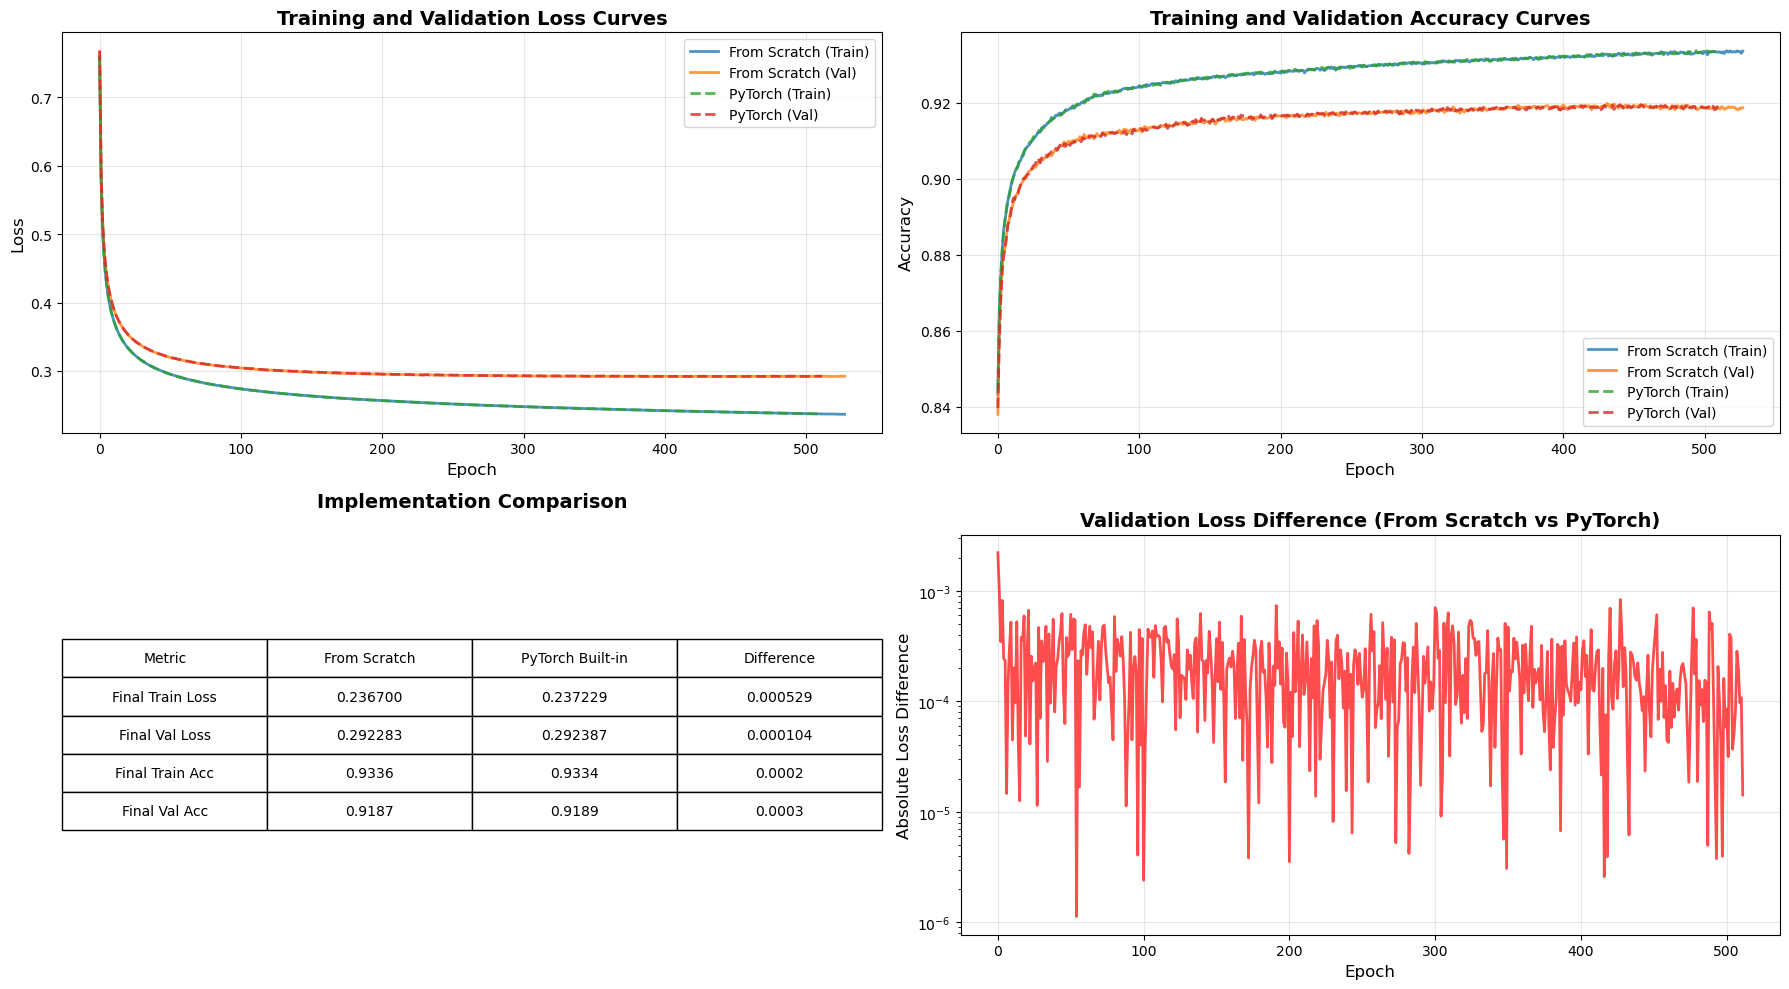


IMPLEMENTATION COMPARISON SUMMARY
Both implementations should produce similar results.
If the differences are very small (< 0.001), our from-scratch implementation is correct!


In [ ]:
# Compare training curves for both implementations
plt.figure(figsize=(18, 10))

# Loss curves
plt.subplot(2, 2, 1)
plt.plot(train_losses_scratch, label='From Scratch (Train)', linewidth=2, alpha=0.8)
plt.plot(val_losses_scratch, label='From Scratch (Val)', linewidth=2, alpha=0.8)
plt.plot(train_losses_pytorch, label='PyTorch (Train)', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(val_losses_pytorch, label='PyTorch (Val)', linewidth=2, linestyle='--', alpha=0.8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(2, 2, 2)
plt.plot(train_accuracies_scratch, label='From Scratch (Train)', linewidth=2, alpha=0.8)
plt.plot(val_accuracies_scratch, label='From Scratch (Val)', linewidth=2, alpha=0.8)
plt.plot(train_accuracies_pytorch, label='PyTorch (Train)', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(val_accuracies_pytorch, label='PyTorch (Val)', linewidth=2, linestyle='--', alpha=0.8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Final comparison table
plt.subplot(2, 2, 3)
plt.axis('off')
comparison_data = [
    ['Metric', 'From Scratch', 'PyTorch Built-in', 'Difference'],
    ['Final Train Loss', f'{train_losses_scratch[-1]:.6f}', f'{train_losses_pytorch[-1]:.6f}', 
     f'{abs(train_losses_scratch[-1] - train_losses_pytorch[-1]):.6f}'],
    ['Final Val Loss', f'{val_losses_scratch[-1]:.6f}', f'{val_losses_pytorch[-1]:.6f}', 
     f'{abs(val_losses_scratch[-1] - val_losses_pytorch[-1]):.6f}'],
    ['Final Train Acc', f'{train_accuracies_scratch[-1]:.4f}', f'{train_accuracies_pytorch[-1]:.4f}', 
     f'{abs(train_accuracies_scratch[-1] - train_accuracies_pytorch[-1]):.4f}'],
    ['Final Val Acc', f'{val_accuracies_scratch[-1]:.4f}', f'{val_accuracies_pytorch[-1]:.4f}', 
     f'{abs(val_accuracies_scratch[-1] - val_accuracies_pytorch[-1]):.4f}'],
]
table = plt.table(cellText=comparison_data[1:], colLabels=comparison_data[0], 
                  cellLoc='center', loc='center', colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Implementation Comparison', fontsize=14, fontweight='bold', pad=20)

# Loss difference plot
plt.subplot(2, 2, 4)
min_len = min(len(val_losses_scratch), len(val_losses_pytorch))
loss_diff = [abs(v1 - v2) for v1, v2 in zip(val_losses_scratch[:min_len], val_losses_pytorch[:min_len])]
plt.plot(loss_diff, linewidth=2, color='red', alpha=0.7)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Absolute Loss Difference', fontsize=12)
plt.title('Validation Loss Difference (From Scratch vs PyTorch)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()



### Final Test Evaluation



In [ ]:
# Evaluate from-scratch model on test set
test_loss_scratch, test_acc_scratch = evaluate_softmax(model_scratch, test_loader_multi)

# Evaluate PyTorch model on test set
test_loss_pytorch, test_acc_pytorch = evaluate_pytorch(model_pytorch, test_loader_multi, criterion)

print(f"\nFrom Scratch Implementation:")
print(f"  Test Accuracy: {test_acc_scratch:.4f} ({test_acc_scratch*100:.2f}%)")
print(f"  Test Loss: {test_loss_scratch:.6f}")
print(f"\nPyTorch Built-in Implementation:")
print(f"  Test Accuracy: {test_acc_pytorch:.4f} ({test_acc_pytorch*100:.2f}%)")
print(f"  Test Loss: {test_loss_pytorch:.6f}")
print(f"\nDifference:")
print(f"  Accuracy difference: {abs(test_acc_scratch - test_acc_pytorch):.6f}")
print(f"  Loss difference: {abs(test_loss_scratch - test_loss_pytorch):.6f}")


FINAL TEST RESULTS

From Scratch Implementation:
  Test Accuracy: 0.9199 (91.99%)
  Test Loss: 0.285589

PyTorch Built-in Implementation:
  Test Accuracy: 0.9203 (92.03%)
  Test Loss: 0.285665

Difference:
  Accuracy difference: 0.000417
  Loss difference: 0.000076


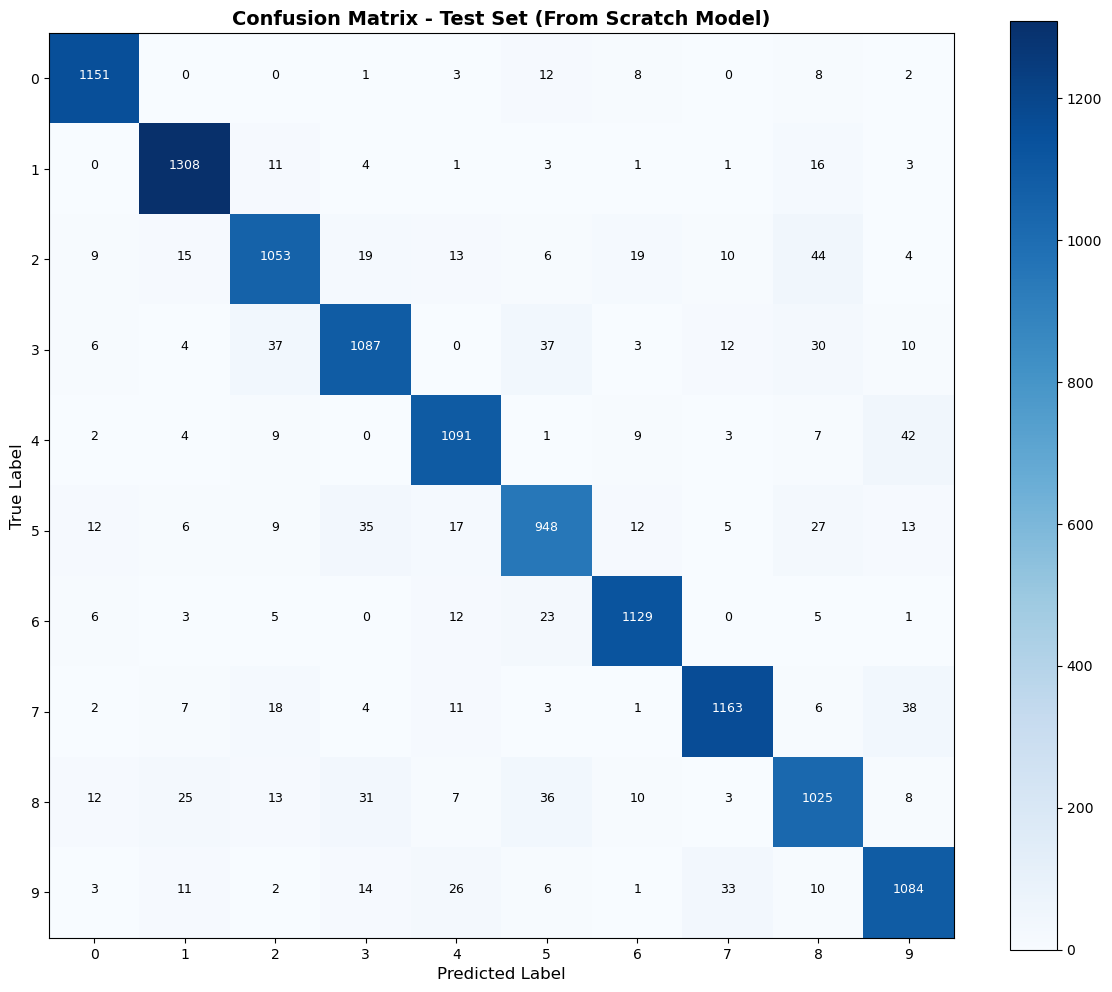


Confusion Matrix (From Scratch Model):
True\Pred       0       1       2       3       4       5       6       7       8       9
    0       1151       0       0       1       3      12       8       0       8       2
    1          0    1308      11       4       1       3       1       1      16       3
    2          9      15    1053      19      13       6      19      10      44       4
    3          6       4      37    1087       0      37       3      12      30      10
    4          2       4       9       0    1091       1       9       3       7      42
    5         12       6       9      35      17     948      12       5      27      13
    6          6       3       5       0      12      23    1129       0       5       1
    7          2       7      18       4      11       3       1    1163       6      38
    8         12      25      13      31       7      36      10       3    1025       8
    9          3      11       2      14      26       6       1     

In [ ]:
# Create confusion matrix for from-scratch model
y_test_true_all = []
y_test_pred_scratch_all = []

with torch.no_grad():
    for batch_X, batch_y in test_loader_multi:
        predictions = model_scratch.predict(batch_X)
        y_test_true_all.extend(batch_y.numpy())
        y_test_pred_scratch_all.extend(predictions.numpy())

y_test_true_all = np.array(y_test_true_all)
y_test_pred_scratch_all = np.array(y_test_pred_scratch_all)

# Confusion matrix
cm_scratch = confusion_matrix(y_test_true_all, y_test_pred_scratch_all)

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm_scratch, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set (From Scratch Model)', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add text annotations
thresh = cm_scratch.max() / 2.
for i in range(10):
    for j in range(10):
        plt.text(j, i, format(cm_scratch[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm_scratch[i, j] > thresh else "black",
                fontsize=9)

plt.tight_layout()
plt.show()




PER-CLASS ACCURACY ANALYSIS
Class 0: 0.9713 (1151/1185)
Class 1: 0.9703 (1308/1348)
Class 2: 0.8834 (1053/1192)
Class 3: 0.8866 (1087/1226)
Class 4: 0.9341 (1091/1168)
Class 5: 0.8745 (948/1084)
Class 6: 0.9535 (1129/1184)
Class 7: 0.9282 (1163/1253)
Class 8: 0.8761 (1025/1170)
Class 9: 0.9109 (1084/1190)


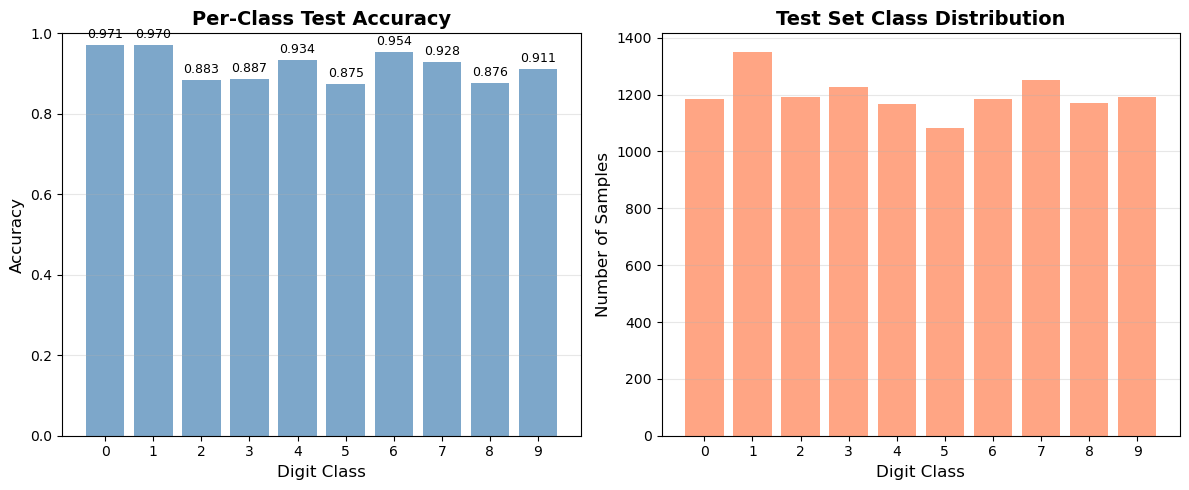


Overall Test Accuracy: 0.9199
Average Per-Class Accuracy: 0.9189
Worst Class Accuracy: 0.8745 (Class 5)
Best Class Accuracy: 0.9713 (Class 0)


In [ ]:
# Per-class accuracy analysis
print("PER-CLASS ACCURACY ANALYSIS")

class_names = [str(i) for i in range(10)]
class_accuracies = []
class_counts = []

for class_idx in range(10):
    # Find samples of this class
    mask = y_test_true_all == class_idx
    class_samples = np.sum(mask)
    class_counts.append(class_samples)
    
    # Count correct predictions for this class
    correct = np.sum((y_test_true_all == class_idx) & (y_test_pred_scratch_all == class_idx))
    accuracy = correct / class_samples if class_samples > 0 else 0.0
    class_accuracies.append(accuracy)
    
    print(f"Class {class_idx}: {accuracy:.4f} ({correct}/{class_samples})")

# Visualize per-class accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(class_names, class_accuracies, color='steelblue', alpha=0.7)
plt.xlabel('Digit Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

# Class distribution in test set
plt.subplot(1, 2, 2)
plt.bar(class_names, class_counts, color='coral', alpha=0.7)
plt.xlabel('Digit Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Test Set Class Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nOverall Test Accuracy: {test_acc_scratch:.4f}")
print(f"Average Per-Class Accuracy: {np.mean(class_accuracies):.4f}")
print(f"Worst Class Accuracy: {np.min(class_accuracies):.4f} (Class {np.argmin(class_accuracies)})")
print(f"Best Class Accuracy: {np.max(class_accuracies):.4f} (Class {np.argmax(class_accuracies)})")
